In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Reshape, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
input_shape=[200,200,3]
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Reshape, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Concatenate


In [25]:
img_height, img_width = 250, 250  # Adjust as needed
batch_size = 32
num_channels = 3  # Assuming RGB images

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=to_grayscale_then_rgb,
    validation_split=0.27)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted\Dataset",
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted\Dataset", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 400 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


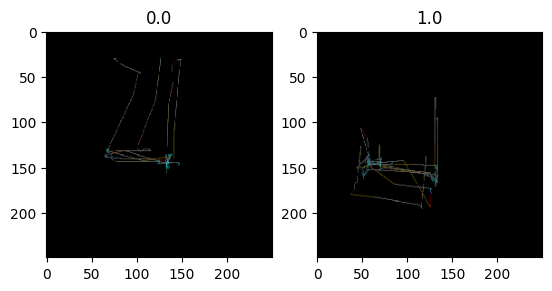

In [28]:
images, labels = train_generator.next()

fig, axes = plt.subplots(1, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
# show the figure
plt.show()

In [35]:
def attention_cnn_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    cnn_output_shape = x.shape[1:]

    # Flatten the feature maps and reshape them into sequences
    x = Flatten()(x)
    x = Reshape((cnn_output_shape[0], -1))(x)

    # Attention layer
    attended_x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)

    # Global average pooling
    avg_pooled_x = GlobalAveragePooling1D()(x)

    # Concatenate attention output and average pooling output
    x = Concatenate()([attended_x, avg_pooled_x])

    # Bi-directional LSTM layer
    x = Bidirectional(LSTM(128))(x)

    # Dense layers and output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)


In [36]:
# Create and compile the model
input_shape = (img_height, img_width, num_channels)
num_classes = 1  # Binary classification
model = improved_attention_cnn_lstm(input_shape, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the ImageDataGenerator
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator))


ValueError: Exception encountered when calling layer "reshape_6" (type Reshape).

total size of new array must be unchanged, input_shape = [107648], output_shape = [31, -1]

Call arguments received by layer "reshape_6" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 107648), dtype=float32)

In [9]:
##Confusion Matrix Generator and ROC Curve
y_pred_real = model.predict(validation_generator)
y_pred = [int(p >= 0.5) for p in y_pred_real] ##With sigmoid 1 neuron
##y_pred = np.argmax(Y_pred, axis=1) ##With softmax and 2 neurons 
y_true = validation_generator.classes
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

147/147 [==============================] - 1s 9ms/step
[[45 43]
 [23 36]]


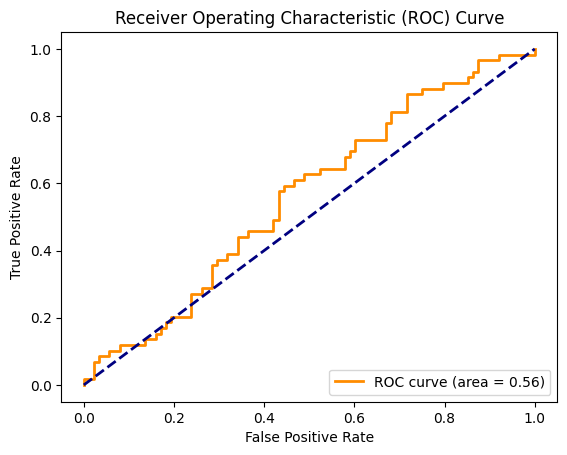

In [10]:
from sklearn.metrics import roc_curve, auc
# Calculate the ROC curve and AUC score, sklearn takes probabilities instead of classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred_real)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()